# 04 - Training Models

In [1]:
# -- Setup -- #

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures (not done in Ch. 02-03)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Linear Regression

Linear regression model prediction

$$\hat{\bf{y}} = h_\theta(\bf x) = \bf{\theta}^T \bf{x}$$

$\theta$ : *parameter vector*, bias term $\theta_0$\n

$\bf x$ : *feature vector*, $x_0 = 1$

$h_\theta$ : *hypothesis fn*, w/ model params $\theta$

MSE of a Linear Regression hypothesis $h_\theta$ on a training set $\bf X$

$$MSE(\theta) = \frac1m \sum_m \left( \theta^T\bf{x^{(i)}} - y^{(i)}\right)^2$$

### The Normal Equation

Closed form solution for $\theta$

$\hat{\bf{\theta}} = (\bf{X}^T\bf X)^{-1} \bf{X}^T y$

Let's generate some 'linear' data to test regression upon.

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


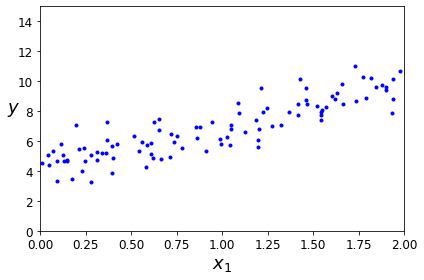

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Compute $\hat \theta$ using normal eq. Use `inv` from `np.linalg`

In [8]:
# Form x_0 component
X_b = np.c_[np.ones((100, 1)), X] # np.c_ translates slice objs to concat. along second axis
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

Note model is $y = 4 + 3x + \epsilon$, w/ $\epsilon$ normally distributed. We see we get close to expected params

In [9]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [10]:
# Make predictions
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best) # hypothesis fn.
y_predict

array([[4.21509616],
       [9.75532293]])

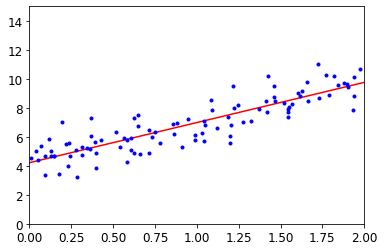

In [11]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()